# Build Micrograd (Part 2)

Video Resource: [YouTube - Micrograd Part 2](https://www.youtube.com/watch?v=VMj-3S1tku0)

Now in the first half of the video we built the basic structure of Micrograd and also understood the backpropagation process manually and with topological sorting.

In this second part, we will start with a clean slate so the code is not all messy and we just have the important parts for automatic differentiation.


In [1243]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [1244]:
class Value:
    
  def __init__(self, data, _children=(), _op='', label = ''):
    """
    Creating Initial Value
    Args:
      data: some numerical value
      grad: gradient of the value (derivative)
      _backward: function to propagate the gradient backward
      _children: a tuple of previous operations
      _op: symbol representing the operation (+, *, etc.)
      label: a string label for the value (name of the variable for visualization)
    """
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out
  
  def __pow__(self, other): # self ** other
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __neg__(self): # -self
    return self * -1
  
  def __sub__(self, other): # self - other
    return self + (-other)
  
  def __rsub__(self, other): # other - self
    return other + (-self)

  def __radd__(self, other): # other + self
    return self + other

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)

    out = Value(t, (self,), 'tanh')

    def _backward():
      self.grad += (1 - t ** 2) * out.grad
    out._backward = _backward

    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self,), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def backward(self):
    # Build the topological order
    topo = []
    visited = set()

    def build_topo(node):
      if node not in visited:
        visited.add(node)
        for child in node._prev:
          build_topo(child)
        topo.append(node)

    build_topo(self)

    # Reverse the topological order
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [1245]:
# This is some copy pasted code that will help visualize the operation chain and it will make sense why are we storing the previous values and operations.

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

# HOW TO USE
# You can use the draw_dot function to visualize the computation graph of a Value object.
# Simply call draw_dot(d) where d is the Value object you want to visualize.


In [1246]:
# Following is an equation for a simple neuron with two inputs
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# apply the tanh activation function
o = n.tanh(); o.label = 'o'

o.backward()

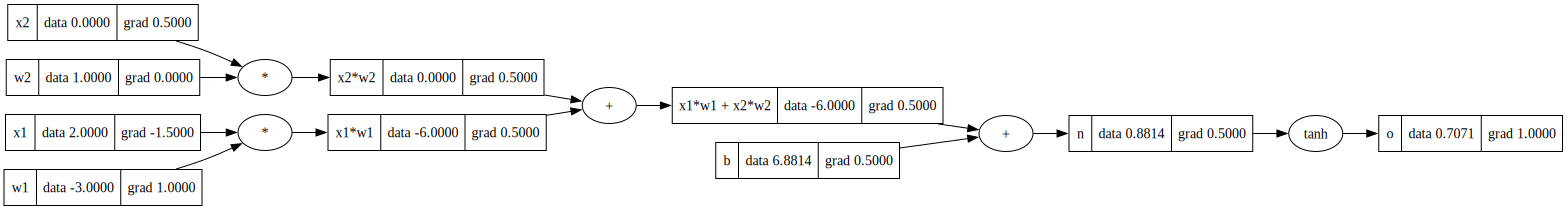

In [1247]:
draw_dot(o)

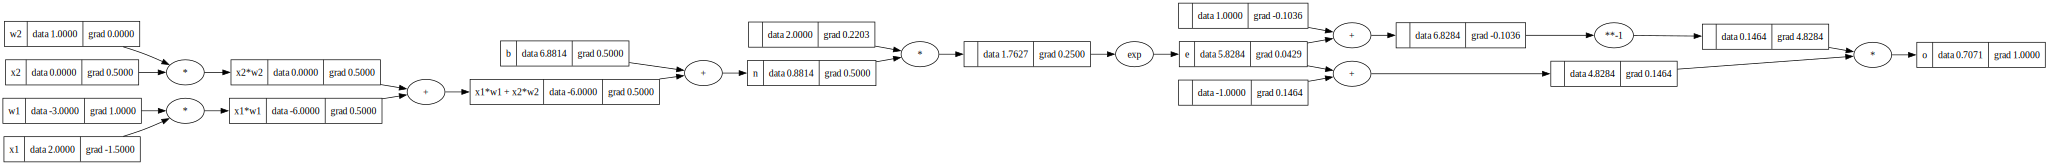

In [1248]:
# Lets edit the old equation so we use different way to do tanh
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# ------------
e = (2*n).exp(); e.label = 'e'
o = (e - 1) / (e + 1)
# ------------
o.label = 'o'

o.backward()

draw_dot(o)

---
## Using PyTorch

Now we will do that same thing we did but a proper library (pytorch). This was some small learning that was based on PyTorch. PyTorch is a powerful library for building and training neural networks, it is used in production by many companies and researchers.


In [1249]:
# in PyTorch we have torch.Tensor instead of Value which we used.
import torch

In [1250]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [1251]:
# Let's work on creating a neuron using micrograd

class Neuron:
	def __init__(self, nin):
		"""
		Initialize the weights and bias for the neuron.
		
		Args:
		nin (int): The number of input connections to the neuron.
		"""
		self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # weights
		self.b = Value(random.uniform(-1,1)) # bias
        
	def __call__(self, x):
		"""
		This function computes the output of the neuron for a given input. i.e. y = f(wx + b)
		"""
		# we will calculate the activation. i.e. Σ(wi*xi) + b. Here zip will create pairs of (wi, xi) in tuples and we will iterate on that to do wi*xi and sum them up starting from self.b instead of 0.0 for efficiency
		activation = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)

		# now on top of that we will have an activation function. here it will be tanh
		output = activation.tanh()

		return output
	
	def parameters(self):
		"""
		This function returns all the parameters (weights and bias) of the neuron as a list.
		
		Returns:
		list of Value: The weights and bias of the neuron.
		"""
		return self.w + [self.b]
	

# now that we have created one single neuron using micrograd, we will create a layer
# a layer is bunch of neurons working together
class Layer:
	def __init__(self, nin, nout):
		"""
		Initialize the layer with a given number of input and output neurons.
		So one neuron takes n number of inputs (nin) and produces one output.
		So we will create n number of neurons (nout) in the layer to generate n number of outputs.

		Args:
		nin (int): The number of input connections for each neuron in the layer.
		nout (int): The number of neurons to create so we get n number of outputs.
		"""
		self.neurons = [Neuron(nin) for _ in range(nout)] # create nout neurons each with nin inputs

	def __call__(self, x):
		"""
		This function computes the output of the layer for a given input by passing the input through each neuron in the layer. That means all inputs are given to each neuron to generate list of outputs.

		Args:
		x (list of float): The input values to the layer.

		Returns:
		Value or list of Value: Single Value if one neuron, else list of Values.
		"""
		out = [n(x) for n in self.neurons] # pass the input x through each neuron

		return out[0] if len(out) == 1 else out  # unwrap single-element lists
	
	def parameters(self):
		"""
		This function returns all the parameters (weights and bias) of all neurons in the layer as a list.
		
		Returns:
		list of Value: The weights and bias of all neurons in the layer.
		"""
		return [p for neuron in self.neurons for p in neuron.parameters()]
	

# Now when we have layer of Layers we call it a Multi-Layer Perceptron (MLP)
# A MLP is just mutliple layers stacked together to form a neural network
class MLP:
	def __init__(self, nin, nouts):
		"""
		Initialize the MLP with a given number of input connections and a list of output sizes for each layer.
		So we will create multiple layers where each layer has its own number of neurons.

		Args:
		nin (int): The number of input connection for the first layer.
		nouts (list of int): A list where each element represents the number of neurons in that layer.
		"""
		sizes = [nin] + nouts # sizes will be [input_size, layer1_size, layer2_size, ...]
		self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(nouts))] # create layers based on sizes

	def __call__(self, x):
		"""
		This function computes the output of the MLP for a given input by passing the input through each layer in sequence.

		Args:
		x (list of float): The input values to the MLP. The length of x should match the input size of the first layer.

		Returns:
		list of Value: The output values from the final layer of the MLP.
		"""
		for layer in self.layers:
			x = layer(x) # pass the input through each layer sequentially
		return x
	
	def parameters(self):
		"""
		This function returns all the parameters (weights and bias) of all layers in the MLP as a list.
		
		Returns:
		list of Value: The weights and bias of all layers in the MLP.
		"""
		return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0] # input to the neuron
neuron = Neuron(len(x)) # create a neuron with inputs as the length of x
print(f"Output of neuron: {neuron(x)}")

layer = Layer(len(x), 3) # create a layer with 3 neurons each managing the same inputs
print(f"Output of layer: {layer(x)}")

mlp = MLP(len(x), [4,4,1]) # create a MLP with 2 hidden layers of 4 neurons each and 1 output neuron
print(f"Output of MLP: {mlp(x)}")


# Here what we create is a simple neural network where we have a list of values as input and we run those inputs through a MLP. MLP class generates multiple layers using the layer class and each layer creates multiple neurons using the Neuron class. The inputs travel in neurons from layer to layer until we get the final output. For example: MLP(len(x), [4,4,1]) means if we have input as [2.0, 3.0] then first input layer will be [2.0, 3.0] -> first hidden layer with 4 neurons each getting the same input and each neuron will produce 1 output i.e. 4 outputs in total -> second hidden layer with 4 neurons each getting the 4 outputs from previous layer as input and each neuron will produce 1 output i.e. 4 outputs in total -> final output layer with 1 neuron getting the 4 outputs from previous layer as input and producing 1 final output.

Output of neuron: Value(data=-0.7710561305253687)
Output of layer: [Value(data=0.9776904530194682), Value(data=0.5918602274456335), Value(data=0.9968643794873867)]
Output of MLP: Value(data=-0.3541342384552519)


---
## Understanding the Code Flow for the above Implementation of Neuron, Layer, and MLP Classes as Forward Pass.

### 1. Neuron Class

A **Neuron** is the basic unit. It takes `nin` inputs and produces 1 output.

**Initialization (`__init__`):**
```
Neuron(2) creates:
├── self.w = [Value(random), Value(random)]  ← 2 weights (one per input)
└── self.b = Value(random)                    ← 1 bias
```

**Forward Pass (`__call__`):**
```
Input: x = [2.0, 3.0]

Step 1: zip(weights, inputs) → [(w0, 2.0), (w1, 3.0)]
Step 2: Compute weighted sum starting from bias
        → b + (w0 * 2.0) + (w1 * 3.0)
Step 3: Apply tanh activation
        → tanh(weighted_sum) → output ∈ [-1, 1]
```

---

### 2. Layer Class

A **Layer** is a collection of neurons. Each neuron receives the **same input** but has **different weights**.

**Initialization (`__init__`):**
```
Layer(2, 3) creates:
└── self.neurons = [Neuron(2), Neuron(2), Neuron(2)]  ← 3 neurons, each with 2 inputs
```

**Forward Pass (`__call__`):**
```
Input: x = [2.0, 3.0]

All neurons receive the SAME input:
├── Neuron 0: [2.0, 3.0] → w0·x + b0 → tanh → out0
├── Neuron 1: [2.0, 3.0] → w1·x + b1 → tanh → out1
└── Neuron 2: [2.0, 3.0] → w2·x + b2 → tanh → out2

Output: [out0, out1, out2]  ← 3 values (one per neuron)
```

---

### 3. MLP Class (Multi-Layer Perceptron)

An **MLP** stacks multiple layers. The output of one layer becomes the input to the next.

**Initialization (`__init__`):**
```
MLP(2, [4, 4, 1]) creates:

sizes = [2, 4, 4, 1]  ← [input_size, layer1, layer2, layer3]

self.layers:
├── Layer(2, 4)  ← 4 neurons, each takes 2 inputs  → outputs 4 values
├── Layer(4, 4)  ← 4 neurons, each takes 4 inputs  → outputs 4 values
└── Layer(4, 1)  ← 1 neuron,  takes 4 inputs       → outputs 1 value
```

**Forward Pass (`__call__`):**
```
Input: x = [2.0, 3.0]

    [2.0, 3.0]         ← 2 inputs
         │
         ▼
    ┌─────────┐
    │ Layer 0 │        4 neurons × 2 weights each
    └─────────┘
         │
    [v, v, v, v]       ← 4 values
         │
         ▼
    ┌─────────┐
    │ Layer 1 │        4 neurons × 4 weights each
    └─────────┘
         │
    [v, v, v, v]       ← 4 values
         │
         ▼
    ┌─────────┐
    │ Layer 2 │        1 neuron × 4 weights
    └─────────┘
         │
       [v]             ← 1 final output
```

---

### Key Takeaways

| Component | Input | Output | Purpose |
|-----------|-------|--------|---------|
| **Neuron** | n values | 1 value | Weighted sum + activation |
| **Layer** | n values | m values | Multiple neurons in parallel |
| **MLP** | n values | k values | Layers connected in sequence |

The beauty of using `Value` objects is that every operation builds a **computation graph**. When you call `.backward()` on the final output, gradients automatically propagate back through the entire network!

## Loss Calculation and Backpropagation

Now that we have our MLP, we need to **train** it. Training means adjusting the weights so the network produces outputs closer to what we want.

### The Training Process

```
1. FORWARD PASS: Input → MLP → Predicted Output (ypred)
2. LOSS CALCULATION: Compare ypred with desired output (y) → Loss value
3. BACKWARD PASS: Compute gradients (how much each weight affects the loss)
4. UPDATE WEIGHTS: Adjust weights in the direction that reduces loss
5. REPEAT until loss is small enough
```

### What is Loss?

**Loss** measures how "wrong" our predictions are. We use **Mean Squared Error (MSE)**:

```
Loss = Σ (predicted - actual)²
```

- If prediction = actual → loss = 0 (perfect!)
- The bigger the difference → the bigger the loss

### Example

| Input | Desired Output | Predicted | Error | Squared Error |
|-------|---------------|-----------|-------|---------------|
| [2,3,-1] | 1.0 | 0.7 | -0.3 | 0.09 |
| [3,-1,0.5] | -1.0 | 0.5 | 1.5 | 2.25 |

Total Loss = 0.09 + 2.25 + ... = some value we want to minimize

### Why Squared?

- Makes all errors positive (no cancellation)
- Penalizes large errors more than small ones
- Mathematically convenient for gradients

In [1252]:
# ============================================
# TRAINING DATA
# ============================================

# Input samples: each row is one training example with 3 features
inputs = [
    [2.0, 3.0, -1.0],   # sample 1
    [3.0, -1.0, 0.5],   # sample 2
    [0.5, 1.0, 1.0],    # sample 3
    [1.0, 1.0, -1.0]    # sample 4
]

# Target outputs: what we want the MLP to predict for each input
# This is a simple binary classification: +1 or -1
targets = [1.0, -1.0, -1.0, 1.0]

# Create MLP: 3 inputs -> 4 neurons -> 4 neurons -> 1 output
mlp = MLP(3, [4, 4, 1])

In [1265]:
# ============================================
# TRAINING LOOP
# ============================================

learning_rate = 0.1  # how big of a step to take when updating weights
num_iterations = 100  # how many times to repeat the training process

for iteration in range(num_iterations):
    
    # ----- STEP 1: FORWARD PASS -----
    # Pass each input through the MLP to get predictions
    predictions = [mlp(x) for x in inputs]
    
    # ----- STEP 2: CALCULATE LOSS -----
    # Mean Squared Error: sum of (prediction - target)^2
    loss = sum((pred - target)**2 for target, pred in zip(targets, predictions))
    
    # ----- STEP 3: ZERO GRADIENTS -----
    # Reset all gradients to 0 before backward pass
    # (gradients accumulate by default, so we need to clear them)
    for param in mlp.parameters():
        param.grad = 0.0

    # ----- STEP 4: BACKWARD PASS -----
    # Compute gradients: how much each weight affects the loss
    loss.backward()
    
    # ----- STEP 5: UPDATE WEIGHTS -----
    # Gradient descent: move weights in the opposite direction of gradient
    # weight = weight - learning_rate * gradient
    for param in mlp.parameters():
        param.data += -learning_rate * param.grad

    # Print progress every 10 iterations
    if iteration % 10 == 0:
        print(f"Iteration {iteration:3d} | Loss: {loss.data:.6f}")

# Final results
print("\n" + "="*50)
print("TRAINING COMPLETE")
print("="*50)
print(f"Final Loss: {loss.data:.6f}")
print(f"\nPredictions vs Targets:")
for i, (pred, target) in enumerate(zip(predictions, targets)):
    print(f"  Sample {i+1}: predicted {pred.data:+.4f}, target {target:+.1f}")

Iteration   0 | Loss: 0.000278
Iteration  10 | Loss: 0.000276
Iteration  20 | Loss: 0.000274
Iteration  30 | Loss: 0.000271
Iteration  40 | Loss: 0.000269
Iteration  50 | Loss: 0.000266
Iteration  60 | Loss: 0.000264
Iteration  70 | Loss: 0.000262
Iteration  80 | Loss: 0.000260
Iteration  90 | Loss: 0.000258

TRAINING COMPLETE
Final Loss: 0.000256

Predictions vs Targets:
  Sample 1: predicted +0.9939, target +1.0
  Sample 2: predicted -0.9921, target -1.0
  Sample 3: predicted -0.9916, target -1.0
  Sample 4: predicted +0.9908, target +1.0
